# Random Forest Regressor

In [1]:
%load_ext autoreload

import pandas as pd
import feather
import numpy as np
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor
from fastai.structured import draw_tree
import math
import os
# Required for visualizing the tree
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Reading a dataset which is stored in feather format for fast read. proc_df is employed to process the dataframe. proc_df utilizes fastai library to encode categorical entries, create necessary datetime features and some other minor operations.

In [2]:
df_raw = pd.read_feather('data/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [3]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

For testing the dataset, a subset of the data containing only two columns is utilized.

In [4]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

## Put Everything Together

In [5]:
class TreeEnsemble():
    # A tree ensemble takes in dependent variable y and independent variable x, the number of trees, the sample-size 
    # to be operated upon and an optional minimum number of leaf entry
    def __init__(self, x, y, n_trees, sample_sz, min_leaf = 5):
        np.random.seed(42)
        # Assign the different variables to object (any instantiation of this class) variables
        self.x, self.y, self.sample_sz, self.min_leaf = x, y, sample_sz, min_leaf
        # Create the required number of trees
        self.trees = [self.create_tree() for i in range(n_trees)]
    
    def create_tree(self):
        # Sub-sampling - Randomness of Random Forest rises from this line. A random sample of size sample_sz is created
        # for every tree
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        # DecisionTree object of DecisionTree class is created by passing the random sample and the minimum no of leaf
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)
    
    def predict(self, x):
        # The prediction of the RandomForest is the mean of the predictions of all trees
        return np.mean([t.predict(x) for t in self.trees], axis = 0)

Standard Deviation - Alternative Formula = $\sqrt {\frac{{\sum {x_i^2} }}{N}\, - \,{{\left( {\frac{{\sum x_i }}{N}} \right)}^2}} $ 

square root of mean of squares/n - square of mean/n

In [6]:
# Faster way to calculate standard deviation
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [7]:
class DecisionTree():
    # A decision tree takes in the sub-sample consisting of dependent variable y and independent variable x and minimum
    # number of leaf
    def __init__(self, x, y, idxs=None, min_leaf = 5):
        # The number of rows on which the decision tree should get constructed is the length of the sub-sample
        if idxs is None: idxs = np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf = x, y, idxs, min_leaf
        # Number of rows and number of columns
        self.n, self.c = len(idxs), x.shape[1]
        # The value of a node is the mean of the independent variable y values present in that node
        self.val = np.mean(y[idxs])
        # The score of the first node is set to infinity as no split is performed
        self.score = float('inf')
        # Find which variable to split on and on what value of the variable to split on
        self.find_varsplit()
    
    # Find which variable to split upon and what value of the variable to split upon and propagates the tree forward
    # if needed
    def find_varsplit(self):
        # Iterate over all variables to find the variable to split upon for the sample in that node
        for i in range(self.c): self.find_better_split(i)
        # If node is a leaf node, skip splitting and exit
        if self.is_leaf: return
        # If node is not a leaf node, split on the variable found through find_better_split
        x = self.split_col
        # np.nonzero is a list of indexes of trues - better for storage
        # lhs are those rows which have the variable value less than the split value of that variable
        lhs = np.nonzero(x <= self.split)[0]
        # rhs are those rows which have the variable value greater than the split value of that variable 
        rhs = np.nonzero(x > self.split)[0]
        # Propagate both the lhs and the rhs tree
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    # Find the best possible value to split on for a particular column var_idx    
    def find_better_split(self, var_idx):
        x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
        # Order n based split-finding
        # Sort the column and store the indices of the row in sorted format
        sort_idx = np.argsort(x)
        # Create x and y arrays based on sorted indices
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        # Create count, sum and sum of squares for calculating standard deviation
        # Aim is to find out which split value of variable will give the lowest weighted average of standard deviation
        # on lhs and rhs
        # Initialize all the values into the right hand side of the node being split
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        # Initialize left hand side values to zero
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        # Loop through 0 to number of rows required to keep minimum number of rows in one node
        for i in range(0,self.n - self.min_leaf - 1):
            # Initialize the x and y single value variable with the row entry of the sorted column entry
            xi, yi = sort_x[i], sort_y[i]
            # As we go down the column, the counts are increased in lhs and decreased in rhs
            lhs_cnt += 1; rhs_cnt -= 1
            # As we go down the column, the sum is increased in lhs with that row entry and decreased in rhs
            lhs_sum += yi; rhs_sum -= yi
            # As we go down the column, the sum of squares is increased in lhs with square of that row entry and
            # decreased in lhs
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2

            # skip over if next row entry is same as current, skip over if the number of row entries processed goes
            # below the minimum number of leaf (row entries) required in a node
            if i < self.min_leaf or xi == sort_x[i+1]:
                continue
            
            # standard deviation of lhs is calculated
            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            # standard deviation of rhs is calculated
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            # current score is a weighted average of lhs std and rhs std
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            # check if current score is less than the score of the node. We want the least score possible
            if curr_score < self.score:
                # If yes, store the variable, the score and the split value of the variable
                self.var_idx, self.score, self.split = var_idx, curr_score, xi
        # At the end best split-value of the variable is found

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    # Return all the indices of rows corresponding to a certain column
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    # Check if node is leaf node by finding out if the score is infinity (unchanged)
    @property
    def is_leaf(self): return self.score == float('inf')
    
    # Like a toString function to print tree information (score, split-value and variable upon which split occured)
    def __repr__(self):
        # If leaf node, then only information that can be printed out is the number of rows present in the node and
        # the value of that node (mean of all the y values of that node)
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s
    
    # Prediction of a tree is the array of prediction of each row
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])
    
    # Predicting each row entry
    def predict_row(self, xi):
        # If row entry falls into leaf node, the predicted value is the mean y value of that node
        if self.is_leaf: return self.val
        # If row entry does not fall into leaf node, propagate it into a lhs or rhs based on whether the row value
        # of the column entry present in the node is lesser or greater than the split-value of that column
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        # After propagating, call predict_row again
        return t.predict_row(xi)

In [8]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure', 'Coupler_System', 'saleYear']

In [9]:
# Create a RandomForest Regresssor which has X and Y values that have already been fit
ens = TreeEnsemble(X_train[cols], y_train, n_trees=5, sample_sz=1000)

In [10]:
# Obtain predictions on the validation X and Y
preds = ens.predict(X_valid[cols].values)

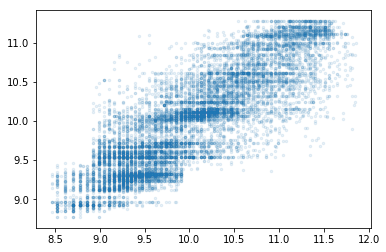

In [11]:
# Plot the y_validation versus predicted y-values
plt.scatter(y_valid, preds, alpha=0.1, s=6);

In [12]:
metrics.r2_score(y_valid, preds)

0.7101174157107124

Scatter Plot and R2 Score indicate decent fit and prediction

Wall time: 14.4 s


0.611599211234717

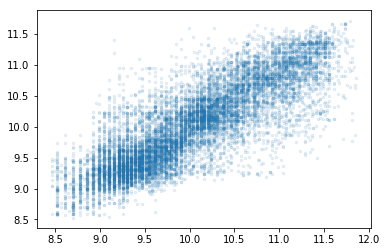

In [13]:
m = RandomForestRegressor(n_estimators=5, min_samples_leaf=5, bootstrap=False)
%time m.fit(X_train[cols], y_train)
preds = m.predict(X_valid[cols].values)
plt.scatter(y_valid, preds, alpha=0.1, s= 6)
metrics.r2_score(preds, y_valid)

Comparison with sklearn RandomForestRegressor indicates performance of custom Random Forest to be greater possibly because of choosing only 1000 sub-samples for the 5 trees in custom Random Forest but this option is unavailable in sklearn. 

This is confirmed by the fact that when the total number of rows (instead of 1000) are passed to Custom Random Forest, R2 score falls significantly due to overfitting and the method of calculating the best split. In the original sklearn Random Forest, split-value is chosen using RMS